# 📰 Kịch Bản 2: Public Benchmark — VNTC
# **Topic:** Robust News Topic Classification Using Deep Learning
# **Mô hình:** KimCNN · BiLSTM+Attention · RCNN · Transformer Encoder · PhoBERT
# **Dataset:** VNTC (Vietnamese News Text Classification) — 10 nhãn tin tức
# > ✅ Bật **GPU**: Runtime → Change runtime type → T4 GPU
# > ⚠️ Chạy **SAU** notebook Kịch bản 1 (VnExpress) để dùng chung `preprocess_text`

In [2]:
## Cell 1 — Cài đặt & Import
!pip install datasets transformers pyvi -q
import re, json
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,
                              classification_report, confusion_matrix)
from pyvi import ViTokenizer
from collections import Counter
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")

✅ Device: cpu


In [3]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from pyvi import ViTokenizer

# Hàm preprocess (giữ nguyên của bạn)
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(
        r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]',
        ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ViTokenizer.tokenize(text)
    return text

print("⏳ Load dataset public benchmark: NamSyntax/vietnamese-news-classification (~1.3M samples)...")

try:
    raw_ds = load_dataset("NamSyntax/vietnamese-news-classification")

    # Load thành DataFrame (thường chỉ có 'train' split)
    df = pd.DataFrame(raw_ds['train'])
    df = df[df['label'] < 10]  # Chỉ giữ lại các nhãn từ 0 đến 9

    print(f"✅ Đã lọc còn 10 nhãn! Tổng mẫu còn lại: {len(df)}")
    print("Nhãn unique hiện tại:", sorted(df['label'].unique()))
    # Kết hợp title + description thành text (dataset này không có 'content' đầy đủ)
    df['text'] = df['title'].fillna('') + ' ' + df['description'].fillna('')
    df = df[['text', 'label']]  # giữ text và label (0-10)

    print(f"✅ Load thành công! Tổng mẫu: {len(df)}")
    print("Nhãn unique:", sorted(df['label'].unique()))

    # Chia train/test stratified (public benchmark fair)
    print("Chia train 80% / test 20% cho benchmark...")
    vntc_train_df, vntc_test_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df['label'],
        random_state=42
    )

except Exception as e:
    print(f"❌ Load thất bại: {e}")
    print("→ Thử login HF nếu cần (hoặc dùng dataset nhỏ hơn ở dưới).")
    raise

# Sampling để chạy nhanh trên Colab
print("\n⏳ Sampling 4k train + 1k test để tối ưu thời gian Benchmark...")

# 1. Lấy 400 mẫu cho mỗi nhãn (Tổng 4,000)
vntc_train_sub = vntc_train_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 400), random_state=42)
).sample(4000, random_state=42)

# 2. Lấy 100 mẫu cho mỗi nhãn (Tổng 1,000)
vntc_test_sub = vntc_test_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 100), random_state=42)
).sample(1000, random_state=42)

# Tiền xử lý subsample (Lúc này chỉ mất ~30 giây)
print("⏳ Tiền xử lý văn bản...")
vntc_train_sub['text_clean'] = vntc_train_sub['text'].apply(preprocess_text)
vntc_test_sub['text_clean']  = vntc_test_sub['text'].apply(preprocess_text)

# Gán biến và chia tập Validation (10% của 4k = 400 mẫu)
vntc_train_final, vntc_val_final = train_test_split(
    vntc_train_sub,
    test_size=0.1,
    stratify=vntc_train_sub['label'],
    random_state=42
)

vntc_test_df = vntc_test_sub

print("✅ Hoàn tất thiết lập 4.000 mẫu!")
print(f"Train final: {len(vntc_train_final)} | Val: {len(vntc_val_final)} | Test: {len(vntc_test_df)}")

⏳ Load dataset public benchmark: NamSyntax/vietnamese-news-classification (~1.3M samples)...
✅ Đã lọc còn 10 nhãn! Tổng mẫu còn lại: 1260143
Nhãn unique hiện tại: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
✅ Load thành công! Tổng mẫu: 1260143
Nhãn unique: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Chia train 80% / test 20% cho benchmark...

⏳ Sampling 4k train + 1k test để tối ưu thời gian Benchmark...


/tmp/ipython-input-16946/2686123785.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vntc_train_sub = vntc_train_df.groupby('label', group_keys=False).apply(
/tmp/ipython-input-16946/2686123785.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vntc_test_sub = vntc_test_df.groupby('label', group_keys=False).apply(


⏳ Tiền xử lý văn bản...
✅ Hoàn tất thiết lập 4.000 mẫu!
Train final: 3600 | Val: 400 | Test: 1000


In [5]:
## Cell 3 — Label Map & Vocab
label_map_vntc = {int(l): i for i, l in enumerate(sorted(vntc_train_final['label'].unique()))}
OUTPUT_DIM_VNTC = len(label_map_vntc)
print("Label map VNTC (NamSyntax version - 10 lớp):", label_map_vntc)
print(f"Số nhãn: {OUTPUT_DIM_VNTC}")

# Vocab (giữ nguyên)
all_words = ' '.join(vntc_train_final['text_clean']).split()
wc = Counter(all_words)
vocab_vntc = {w: i+2 for i, (w, c) in enumerate(wc.items()) if c >= 2}
vocab_vntc['<PAD>'] = 0
vocab_vntc['<UNK>'] = 1
VOCAB_SIZE = max(vocab_vntc.values()) + 1
EMBED_DIM = 128
HIDDEN_DIM = 128
print(f"Vocab size: {VOCAB_SIZE}")

Label map VNTC (NamSyntax version - 10 lớp): {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
Số nhãn: 10
Vocab size: 11984


In [6]:
## Cell 4 — Dataset & DataLoader Classes
# ── SeqDataset: cho KimCNN / BiLSTM / RCNN / Transformer ─────
def text_to_seq(text, vocab, max_len=300):
    tokens = str(text).split()
    seq = [vocab.get(t, vocab['<UNK>']) for t in tokens]
    if len(seq) < max_len: seq += [vocab['<PAD>']] * (max_len - len(seq))
    else: seq = seq[:max_len]
    return seq
class SeqDataset(Dataset):
    def __init__(self, df, vocab, label_map, max_len=300):
        self.seqs = [text_to_seq(t, vocab, max_len) for t in df['text_clean']]
        self.labels = [label_map[l] for l in df['label']]
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return (torch.tensor(self.seqs[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.long))
# ── PhoDataset: cho PhoBERT ────────────────────────────────────
class PhoDataset(Dataset):
    def __init__(self, df, tokenizer, label_map, max_len=128):
        self.texts = df['text_clean'].fillna("").astype(str).values
        self.labels = df['label'].map(label_map).values
        self.tokenizer = tokenizer
        self.max_len = max_len
        nans = pd.isna(self.labels).sum()
        if nans > 0:
            raise ValueError(f"❌ {nans} nhãn không map được!")
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True,
                             add_special_tokens=True, max_length=self.max_len,
                             padding='max_length', return_tensors='pt')
        return {'input_ids': enc['input_ids'].flatten(),
                'attention_mask': enc['attention_mask'].flatten(),
                'labels': torch.tensor(int(self.labels[idx]), dtype=torch.long)}
# ── DataLoaders ────────────────────────────────────────────────
trn_seq = DataLoader(SeqDataset(vntc_train_final, vocab_vntc, label_map_vntc),
                     batch_size=64, shuffle=True)  # Tăng batch size để giảm overfitting
val_seq = DataLoader(SeqDataset(vntc_val_final, vocab_vntc, label_map_vntc),
                     batch_size=64)
tst_seq = DataLoader(SeqDataset(vntc_test_df, vocab_vntc, label_map_vntc),
                     batch_size=64)
pho_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
MAX_LEN_PHO = 64

trn_pho = DataLoader(PhoDataset(vntc_train_final, pho_tokenizer, label_map_vntc, max_len=MAX_LEN_PHO),
                     batch_size=32, shuffle=True)
val_pho = DataLoader(PhoDataset(vntc_val_final, pho_tokenizer, label_map_vntc, max_len=MAX_LEN_PHO),
                     batch_size=32)
tst_pho = DataLoader(PhoDataset(vntc_test_df, pho_tokenizer, label_map_vntc, max_len=MAX_LEN_PHO),
                     batch_size=32)
print(f"✅ DataLoaders sẵn sàng!")
print(f" Seq → Train={len(trn_seq.dataset)} | Val={len(val_seq.dataset)} | Test={len(tst_seq.dataset)}")
print(f" PhoBERT → Train={len(trn_pho.dataset)} | Val={len(val_pho.dataset)} | Test={len(tst_pho.dataset)}")

✅ DataLoaders sẵn sàng!
 Seq → Train=3600 | Val=400 | Test=1000
 PhoBERT → Train=3600 | Val=400 | Test=1000


In [7]:
## Cell 5 — Kiến Trúc 5 Mô Hình
# ══════════════════════════════════════════════════════
# 1. KimCNN
# ══════════════════════════════════════════════════════
class KimCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n_filters, (fs, embed_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        e = self.embedding(x).unsqueeze(1)
        c = [F.relu(conv(e)).squeeze(3) for conv in self.convs]
        p = [F.max_pool1d(ci, ci.shape[2]).squeeze(2) for ci in c]
        return self.fc(self.dropout(torch.cat(p, dim=1)))
# ══════════════════════════════════════════════════════
# 2. BiLSTM + Attention
# ══════════════════════════════════════════════════════
class BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers,
                               bidirectional=True, dropout=dropout, batch_first=True)
        self.attn_fc = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.v = nn.Parameter(torch.rand(hidden_dim*2))
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        e = self.dropout(self.embedding(x))
        out, _ = self.lstm(e)
        energy = torch.tanh(self.attn_fc(out)).transpose(1,2)
        v = self.v.repeat(x.size(0),1).unsqueeze(1)
        alpha = F.softmax(torch.bmm(v, energy).squeeze(1), dim=1).unsqueeze(-1)
        ctx = (out * alpha).sum(dim=1)
        return self.fc(self.dropout(ctx))
# ══════════════════════════════════════════════════════
# 3. RCNN
# ══════════════════════════════════════════════════════
class RCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim*2 + embed_dim, hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        e = self.embedding(x)
        lstm_out, _ = self.lstm(e)
        combined = torch.cat((lstm_out, e), dim=2)
        y2 = torch.tanh(self.fc1(combined)).permute(0,2,1)
        y3 = F.max_pool1d(y2, y2.size(2)).squeeze(2)
        return self.fc2(self.dropout(y3))
# ══════════════════════════════════════════════════════
# 4. Transformer Encoder
# ══════════════════════════════════════════════════════
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, nhead, nhid, nlayers, output_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, embed_dim))
        enc_layer = nn.TransformerEncoderLayer(embed_dim, nhead, nhid, dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, nlayers)
        self.fc = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        e = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        e = e + self.pos_encoder[:, :x.size(1), :]
        out = self.transformer(e).mean(dim=1)
        return self.fc(self.dropout(out))
# ══════════════════════════════════════════════════════
# 5. PhoBERT + Custom Head
# ══════════════════════════════════════════════════════
class PhoBertClassifier(nn.Module):
    def __init__(self, output_dim, dropout=0.1):
        super().__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(768, output_dim)
    def forward(self, input_ids, attention_mask):
        out = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        return self.fc(self.dropout(cls))
print("✅ 5 model architectures defined!")

✅ 5 model architectures defined!


In [8]:
## Cell 6 — Hàm Train & Evaluate (Dùng chung)
def evaluate_seq(model, loader, criterion):
    model.eval()
    preds, labels = [], []
    total_loss = 0
    with torch.no_grad():
        for texts, lbls in loader:
            texts, lbls = texts.to(device), lbls.to(device)
            outputs = model(texts)
            loss = criterion(outputs, lbls)
            total_loss += loss.item()
            preds.extend(torch.argmax(outputs,1).cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    return labels, preds, total_loss / len(loader)

def train_seq_model(model, train_loader, val_loader, test_loader,
                    label_map, model_name, epochs=12, lr=1e-3, patience=3, weight_decay=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Thêm weight decay
    criterion = nn.CrossEntropyLoss()
    history = {'loss':[], 'val_acc':[], 'val_loss':[]}
    best_val_acc = 0
    patience_counter = 0
    print(f"\n{'='*60}")
    print(f" {model_name}")
    print(f" Train={len(train_loader.dataset)} | Val={len(val_loader.dataset)} | Test={len(test_loader.dataset)}")
    print(f"{'='*60}")
    for epoch in range(epochs):
        model.train(); total_loss = 0
        for texts, lbls in train_loader:
            texts, lbls = texts.to(device), lbls.to(device)
            optimizer.zero_grad()
            loss = criterion(model(texts), lbls)
            loss.backward(); optimizer.step()
            total_loss += loss.item()
        tl_ep, vp, val_loss = evaluate_seq(model, val_loader, criterion)
        va = accuracy_score(tl_ep, vp)
        history['loss'].append(total_loss/len(train_loader))
        history['val_acc'].append(va)
        history['val_loss'].append(val_loss)
        print(f" Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {va:.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping dựa trên val_acc
        if va > best_val_acc:
            best_val_acc = va
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    test_labels, test_preds, _ = evaluate_seq(model, test_loader, criterion)
    return model, history, test_preds, test_labels

def train_pho_model(train_loader, val_loader, test_loader,
                    label_map, model_name, epochs=5, patience=2):
    model = PhoBertClassifier(len(label_map), dropout=0.3).to(device)  # Tăng dropout cho PhoBERT
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)  # Thêm weight decay
    criterion = nn.CrossEntropyLoss()
    history = {'loss':[], 'val_acc':[], 'val_loss':[]}
    best_val_acc = 0
    patience_counter = 0
    print(f"\n{'='*60}")
    print(f" {model_name}")
    print(f" Train={len(train_loader.dataset)} | Val={len(val_loader.dataset)} | Test={len(test_loader.dataset)}")
    print(f"{'='*60}")
    for epoch in range(epochs):
        model.train(); total_loss = 0
        for batch in train_loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            lbls = batch['labels'].to(device)
            optimizer.zero_grad()
            loss = criterion(model(ids, mask), lbls)
            loss.backward(); optimizer.step()
            total_loss += loss.item()
        model.eval(); pv, lv, val_loss = [], [], 0
        with torch.no_grad():
            for batch in val_loader:
                out = model(batch['input_ids'].to(device),
                            batch['attention_mask'].to(device))
                loss = criterion(out, batch['labels'].to(device))
                val_loss += loss.item()
                pv.extend(torch.argmax(out,1).cpu().numpy())
                lv.extend(batch['labels'].numpy())
        va = accuracy_score(lv, pv)
        val_loss /= len(val_loader)
        history['loss'].append(total_loss/len(train_loader))
        history['val_acc'].append(va)
        history['val_loss'].append(val_loss)
        print(f" Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {va:.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if va > best_val_acc:
            best_val_acc = va
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    model.eval(); tp, tl, _ = [], [], 0
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch['input_ids'].to(device),
                        batch['attention_mask'].to(device))
            tp.extend(torch.argmax(out,1).cpu().numpy())
            tl.extend(batch['labels'].numpy())
    return model, history, tp, tl

def print_metrics(test_labels, test_preds, label_map, model_name):
    # Ép kiểu k sang str để tránh lỗi numpy.int64
    tnames = [str(k) for k, v in sorted(label_map.items(), key=lambda x: x[1])]

    acc = accuracy_score(test_labels, test_preds)
    mf1 = f1_score(test_labels, test_preds, average='macro')
    wf1 = f1_score(test_labels, test_preds, average='weighted')

    print(f"\n Accuracy: {acc:.4f} | Macro-F1: {mf1:.4f} | Weighted-F1: {wf1:.4f}")
    print(classification_report(test_labels, test_preds, target_names=tnames))
    return acc, mf1, wf1

def plot_results(history, test_preds, test_labels, label_map, title, cmap='Blues'):
    tnames = [k for k,v in sorted(label_map.items(), key=lambda x:x[1])]
    eps = range(1, len(history['loss'])+1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(title, fontsize=12, fontweight='bold')
    axes[0].plot(eps, history['loss'], 'r-o', lw=2)
    axes[0].set(title='Training Loss', xlabel='Epoch', ylabel='Loss'); axes[0].grid(alpha=0.4)
    axes[1].plot(eps, history['val_acc'], 'b-s', lw=2)
    axes[1].set(title='Val Accuracy', xlabel='Epoch', ylabel='Acc', ylim=(0,1.05)); axes[1].grid(alpha=0.4)
    cm = confusion_matrix(test_labels, test_preds)
    cmn = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap=cmap,
                xticklabels=tnames, yticklabels=tnames, ax=axes[2])
    axes[2].set(title='Confusion Matrix (norm)', xlabel='Dự đoán', ylabel='Thực tế')
    axes[2].tick_params(axis='x', rotation=45)
    plt.tight_layout(); plt.show()
print("✅ Functions ready!")

✅ Functions ready!



 S2 — KimCNN (VNTC)
 Train=3600 | Val=400 | Test=1000
 Epoch 01 | Loss: 2.5382 | Val Acc: 0.3625 | Val Loss: 2.1208
 Epoch 02 | Loss: 2.1035 | Val Acc: 0.4550 | Val Loss: 1.9710
 Epoch 03 | Loss: 1.8509 | Val Acc: 0.4975 | Val Loss: 1.8054
 Epoch 04 | Loss: 1.6648 | Val Acc: 0.5450 | Val Loss: 1.6735
 Epoch 05 | Loss: 1.4650 | Val Acc: 0.5600 | Val Loss: 1.5574
 Epoch 06 | Loss: 1.3599 | Val Acc: 0.5575 | Val Loss: 1.4788
 Epoch 07 | Loss: 1.1948 | Val Acc: 0.6050 | Val Loss: 1.3795
 Epoch 08 | Loss: 1.0782 | Val Acc: 0.6150 | Val Loss: 1.3093
 Epoch 09 | Loss: 0.9662 | Val Acc: 0.6250 | Val Loss: 1.2497
 Epoch 10 | Loss: 0.8811 | Val Acc: 0.6575 | Val Loss: 1.1870
 Epoch 11 | Loss: 0.8111 | Val Acc: 0.6475 | Val Loss: 1.1755
 Epoch 12 | Loss: 0.7224 | Val Acc: 0.6650 | Val Loss: 1.1247

 Accuracy: 0.6670 | Macro-F1: 0.6702 | Weighted-F1: 0.6702
              precision    recall  f1-score   support

           0       0.45      0.54      0.49       100
           1       0.67      0.5

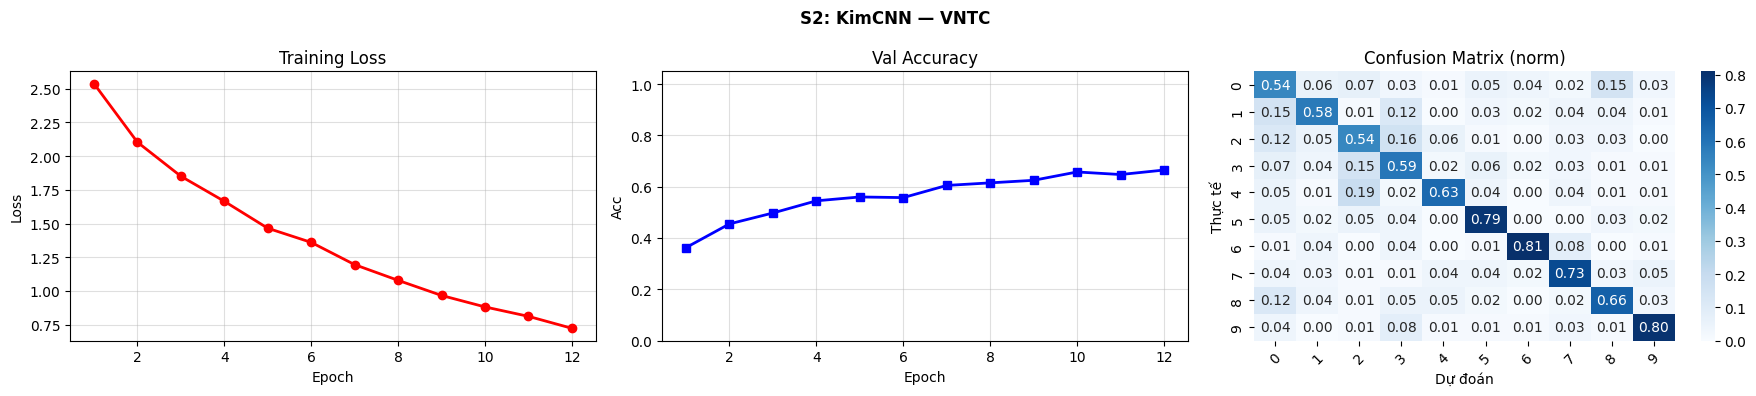

In [9]:
### Cell 7 — KimCNN
if 'results_s2' not in locals():
    results_s2 = {}
model = KimCNN(VOCAB_SIZE, EMBED_DIM, 100, [3,4,5], OUTPUT_DIM_VNTC, 0.6).to(device)  # Tăng dropout
_, h, tp, tl = train_seq_model(model, trn_seq, val_seq, tst_seq,
    label_map_vntc, "S2 — KimCNN (VNTC)", epochs=12)
acc,mf1,wf1 = print_metrics(tl, tp, label_map_vntc, "S2 KimCNN")
results_s2['KimCNN'] = {'Accuracy':acc,'Macro-F1':mf1,'Weighted-F1':wf1}
plot_results(h, tp, tl, label_map_vntc, "S2: KimCNN — VNTC", 'Blues')


 S2 — BiLSTM+Attention (VNTC)
 Train=3600 | Val=400 | Test=1000
 Epoch 01 | Loss: 2.3012 | Val Acc: 0.1150 | Val Loss: 2.2909
 Epoch 02 | Loss: 2.2782 | Val Acc: 0.1725 | Val Loss: 2.2327
 Epoch 03 | Loss: 2.2058 | Val Acc: 0.2350 | Val Loss: 2.1476
 Epoch 04 | Loss: 2.1152 | Val Acc: 0.2950 | Val Loss: 2.0260
 Epoch 05 | Loss: 2.0446 | Val Acc: 0.3000 | Val Loss: 1.9588
 Epoch 06 | Loss: 1.9990 | Val Acc: 0.3750 | Val Loss: 1.8335
 Epoch 07 | Loss: 1.8688 | Val Acc: 0.3625 | Val Loss: 1.8163
 Epoch 08 | Loss: 1.8418 | Val Acc: 0.4100 | Val Loss: 1.7589
 Epoch 09 | Loss: 1.7575 | Val Acc: 0.4450 | Val Loss: 1.6516
 Epoch 10 | Loss: 1.6487 | Val Acc: 0.4325 | Val Loss: 1.5928

 Accuracy: 0.4540 | Macro-F1: 0.4437 | Weighted-F1: 0.4437
              precision    recall  f1-score   support

           0       0.41      0.12      0.19       100
           1       0.71      0.46      0.56       100
           2       0.32      0.12      0.17       100
           3       0.21      0.29     

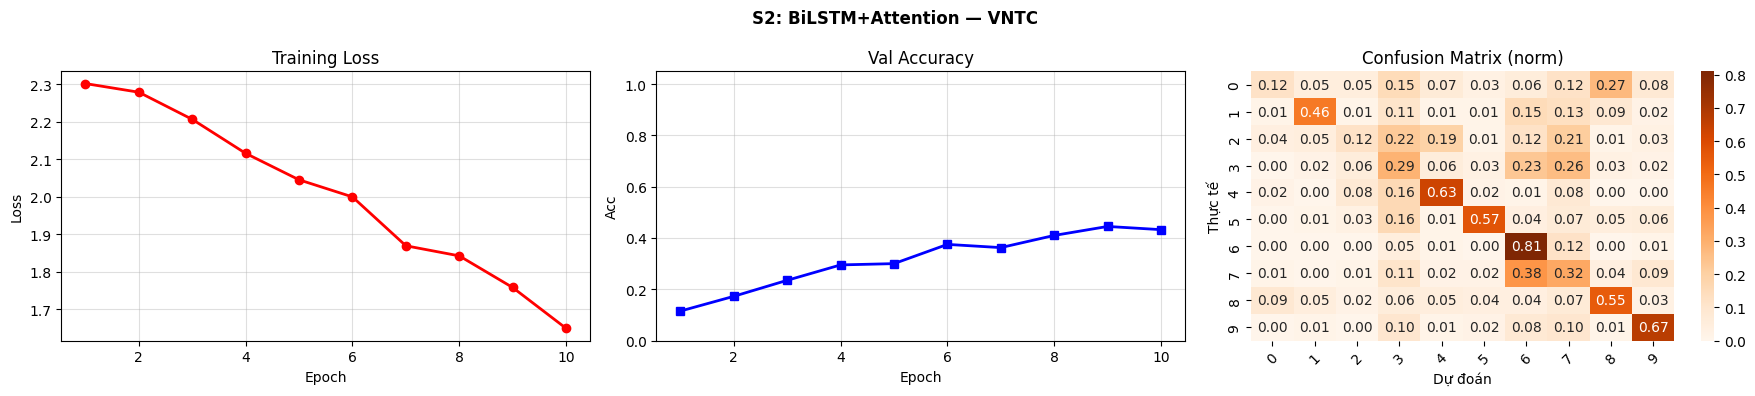

In [10]:
### Cell 8 — BiLSTM + Attention
if 'results_s2' not in locals():
    results_s2 = {}
model = BiLSTM_Attention(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM_VNTC, 2, 0.6).to(device)  # Tăng dropout
_, h, tp, tl = train_seq_model(model, trn_seq, val_seq, tst_seq,
    label_map_vntc, "S2 — BiLSTM+Attention (VNTC)", epochs=10)
acc,mf1,wf1 = print_metrics(tl, tp, label_map_vntc, "S2 BiLSTM+Attention")
results_s2['BiLSTM+Attn'] = {'Accuracy':acc,'Macro-F1':mf1,'Weighted-F1':wf1}
plot_results(h, tp, tl, label_map_vntc, "S2: BiLSTM+Attention — VNTC", 'Oranges')


 S2 — RCNN (VNTC)
 Train=3600 | Val=400 | Test=1000
 Epoch 01 | Loss: 2.3104 | Val Acc: 0.3850 | Val Loss: 2.1626
 Epoch 02 | Loss: 1.9980 | Val Acc: 0.4850 | Val Loss: 1.8371
 Epoch 03 | Loss: 1.5714 | Val Acc: 0.5600 | Val Loss: 1.5169
 Epoch 04 | Loss: 1.2031 | Val Acc: 0.5900 | Val Loss: 1.3398
 Epoch 05 | Loss: 0.9431 | Val Acc: 0.6450 | Val Loss: 1.1799
 Epoch 06 | Loss: 0.7309 | Val Acc: 0.6300 | Val Loss: 1.2000
 Epoch 07 | Loss: 0.5732 | Val Acc: 0.6700 | Val Loss: 1.1201
 Epoch 08 | Loss: 0.4218 | Val Acc: 0.6700 | Val Loss: 1.1222
 Epoch 09 | Loss: 0.3792 | Val Acc: 0.6450 | Val Loss: 1.2446
 Epoch 10 | Loss: 0.3066 | Val Acc: 0.6600 | Val Loss: 1.1544
Early stopping at epoch 10

 Accuracy: 0.6750 | Macro-F1: 0.6743 | Weighted-F1: 0.6743
              precision    recall  f1-score   support

           0       0.55      0.42      0.47       100
           1       0.66      0.69      0.68       100
           2       0.45      0.55      0.50       100
           3       0.61

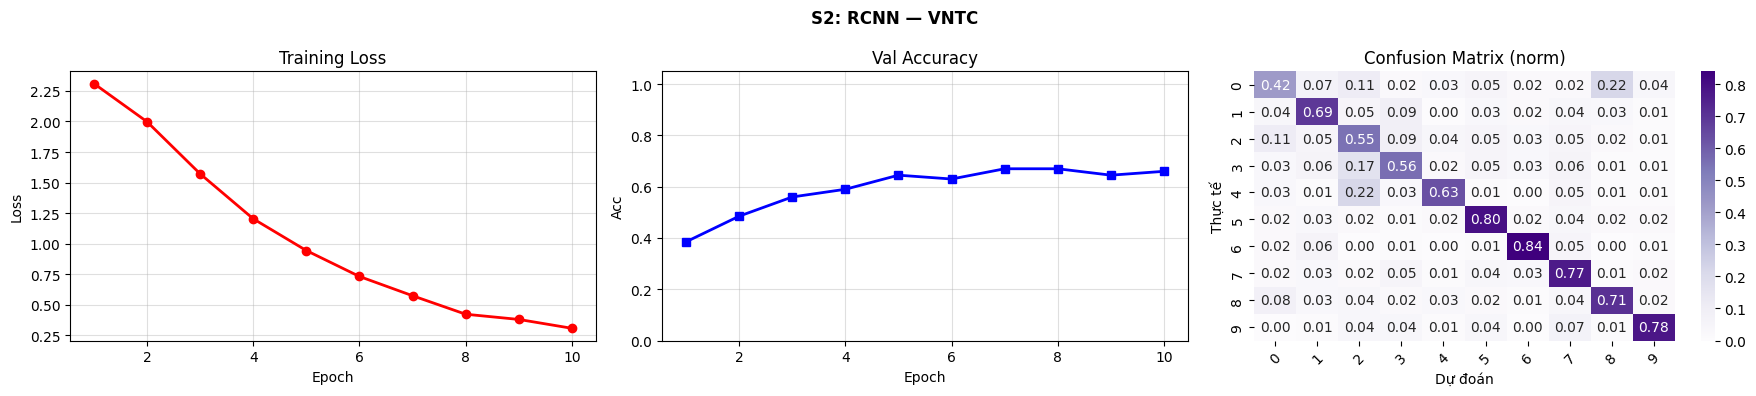

In [11]:
### Cell 9 — RCNN
if 'results_s2' not in locals():
    results_s2 = {}
model = RCNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM_VNTC, 0.6).to(device)  # Tăng dropout
_, h, tp, tl = train_seq_model(model, trn_seq, val_seq, tst_seq,
    label_map_vntc, "S2 — RCNN (VNTC)", epochs=12)
acc,mf1,wf1 = print_metrics(tl, tp, label_map_vntc, "S2 RCNN")
results_s2['RCNN'] = {'Accuracy':acc,'Macro-F1':mf1,'Weighted-F1':wf1}
plot_results(h, tp, tl, label_map_vntc, "S2: RCNN — VNTC", 'Purples')


 S2 — Transformer Encoder (VNTC)
 Train=3600 | Val=400 | Test=1000
 Epoch 01 | Loss: 2.3193 | Val Acc: 0.1675 | Val Loss: 2.3138
 Epoch 02 | Loss: 2.2454 | Val Acc: 0.2000 | Val Loss: 2.2349
 Epoch 03 | Loss: 2.1802 | Val Acc: 0.2650 | Val Loss: 2.1713
 Epoch 04 | Loss: 2.1064 | Val Acc: 0.2800 | Val Loss: 2.1405
 Epoch 05 | Loss: 2.0282 | Val Acc: 0.3075 | Val Loss: 2.1420
 Epoch 06 | Loss: 1.9503 | Val Acc: 0.3325 | Val Loss: 2.1292
 Epoch 07 | Loss: 1.8688 | Val Acc: 0.3625 | Val Loss: 2.0837
 Epoch 08 | Loss: 1.7927 | Val Acc: 0.3975 | Val Loss: 2.0620
 Epoch 09 | Loss: 1.7210 | Val Acc: 0.4125 | Val Loss: 2.0478
 Epoch 10 | Loss: 1.6485 | Val Acc: 0.4275 | Val Loss: 2.0384
 Epoch 11 | Loss: 1.5872 | Val Acc: 0.4450 | Val Loss: 2.0164
 Epoch 12 | Loss: 1.5220 | Val Acc: 0.4725 | Val Loss: 1.9804

 Accuracy: 0.4580 | Macro-F1: 0.4333 | Weighted-F1: 0.4333
              precision    recall  f1-score   support

           0       0.40      0.06      0.10       100
           1       

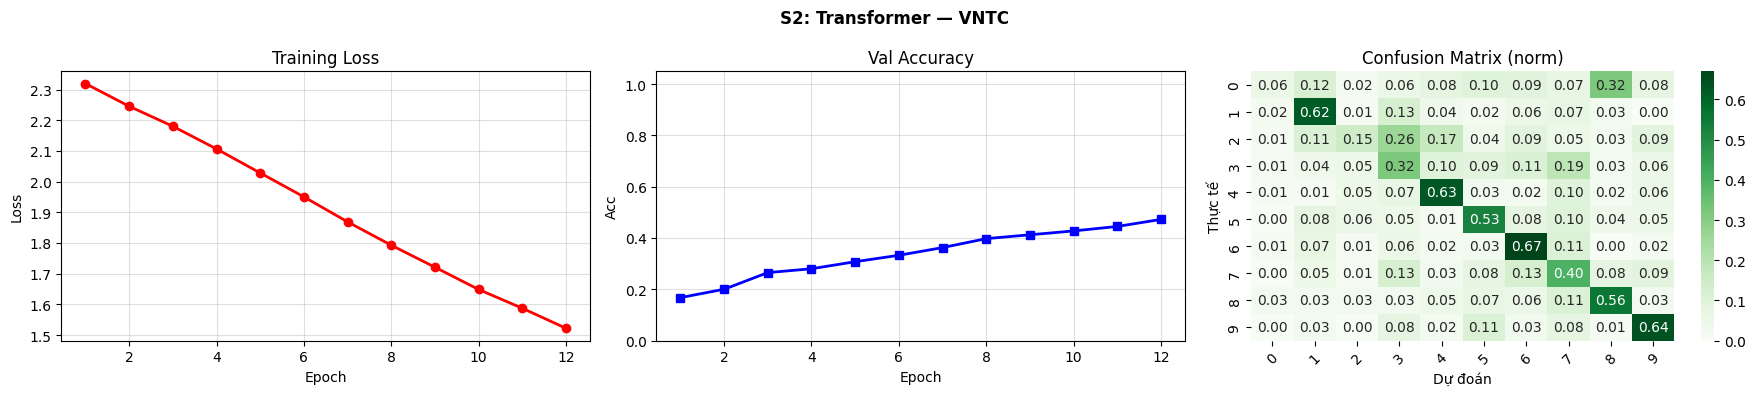

In [12]:
### Cell 10 — Transformer Encoder
if 'results_s2' not in locals():
    results_s2 = {}
model = TransformerClassifier(VOCAB_SIZE, EMBED_DIM, 8, 256, 2, OUTPUT_DIM_VNTC, 0.6).to(device)  # Tăng dropout
_, h, tp, tl = train_seq_model(model, trn_seq, val_seq, tst_seq,
    label_map_vntc, "S2 — Transformer Encoder (VNTC)", epochs=12, lr=1e-4)
acc,mf1,wf1 = print_metrics(tl, tp, label_map_vntc, "S2 Transformer")
results_s2['Transformer'] = {'Accuracy':acc,'Macro-F1':mf1,'Weighted-F1':wf1}
plot_results(h, tp, tl, label_map_vntc, "S2: Transformer — VNTC", 'Greens')

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.dense.weight            | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



 S2 — PhoBERT (VNTC)
 Train=3600 | Val=400 | Test=1000
 Epoch 01 | Loss: 1.4584 | Val Acc: 0.8475 | Val Loss: 0.6619
 Epoch 02 | Loss: 0.6447 | Val Acc: 0.8200 | Val Loss: 0.5725
 Epoch 03 | Loss: 0.4287 | Val Acc: 0.8375 | Val Loss: 0.5129
Early stopping at epoch 3

 Accuracy: 0.8270 | Macro-F1: 0.8237 | Weighted-F1: 0.8237
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       100
           1       0.81      0.87      0.84       100
           2       0.83      0.52      0.64       100
           3       0.81      0.84      0.82       100
           4       0.82      0.90      0.86       100
           5       0.90      0.92      0.91       100
           6       0.97      0.97      0.97       100
           7       0.84      0.92      0.88       100
           8       0.81      0.75      0.78       100
           9       0.89      0.91      0.90       100

    accuracy                           0.83      1000
   macro avg       0.8

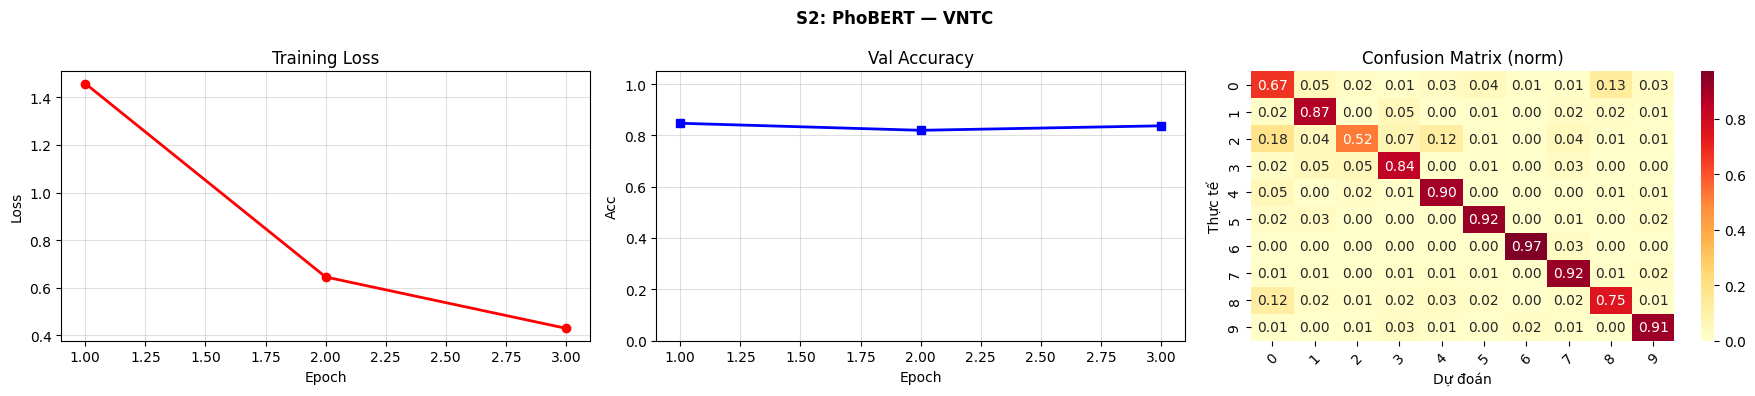

In [13]:
### Cell 11 — PhoBERT + Custom Head
if 'results_s2' not in locals():
    results_s2 = {}

_, h, tp, tl = train_pho_model(trn_pho, val_pho, tst_pho,
    label_map_vntc, "S2 — PhoBERT (VNTC)", epochs=5)
acc,mf1,wf1 = print_metrics(tl, tp, label_map_vntc, "S2 PhoBERT")
results_s2['PhoBERT'] = {'Accuracy':acc,'Macro-F1':mf1,'Weighted-F1':wf1}
plot_results(h, tp, tl, label_map_vntc, "S2: PhoBERT — VNTC", 'YlOrRd')

In [14]:
## Cell 12 — Bảng Tổng Hợp Kịch Bản 2
df_s2 = pd.DataFrame(results_s2).T.reset_index().rename(columns={'index':'Model'})
print("\n" + "="*60)
print(" KẾT QUẢ KỊCH BẢN 2 — PUBLIC BENCHMARK (VNTC) — 5 MÔ HÌNH")
print("="*60)
print(df_s2.round(4).to_string(index=False))


 KẾT QUẢ KỊCH BẢN 2 — PUBLIC BENCHMARK (VNTC) — 5 MÔ HÌNH
      Model  Accuracy  Macro-F1  Weighted-F1
     KimCNN     0.667    0.6702       0.6702
BiLSTM+Attn     0.454    0.4437       0.4437
       RCNN     0.675    0.6743       0.6743
Transformer     0.458    0.4333       0.4333
    PhoBERT     0.827    0.8237       0.8237


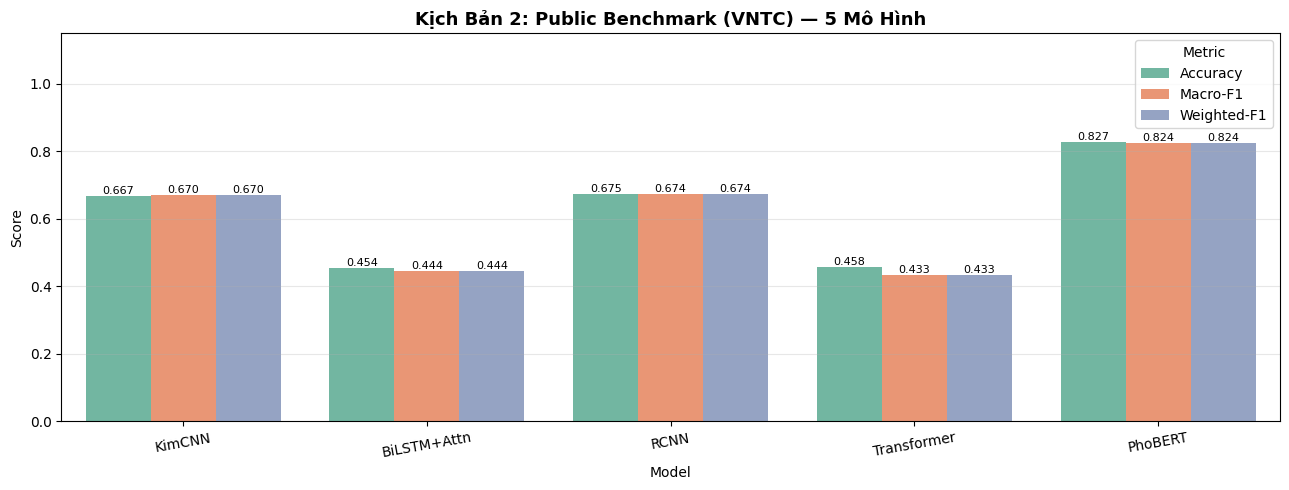

In [15]:
# Bar chart
melted = df_s2.melt('Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(13, 5))
ax = sns.barplot(data=melted, x='Model', y='Score', hue='Metric', palette='Set2')
for p in ax.patches:
    if p.get_height() > 0.01:
        ax.annotate(f'{p.get_height():.3f}',
            (p.get_x()+p.get_width()/2, p.get_height()),
            ha='center', va='bottom', fontsize=8)
plt.title('Kịch Bản 2: Public Benchmark (VNTC) — 5 Mô Hình', fontsize=13, fontweight='bold')
plt.ylim(0, 1.15); plt.xticks(rotation=10); plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('s2_benchmark_results.png', dpi=150, bbox_inches='tight')
plt.show()